In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import rpy2
%load_ext rpy2.ipython
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

## Cancer subtype analysis

In [4]:
df = pd.read_table('CHASMplus/results/subtype_specificity.txt')
df['mutation type'] = 'missense'
#df['gene'] = df['gene'] + ' (M)'
#df2 = pd.read_table('CHASMplus/results/subtype_specificity_tsg.txt')
#df2['mutation type'] = 'inactivating'
#df2['gene'] = df2['gene'] + ' (I)'
#df = pd.concat([df, df2])

In [5]:
df['significant'] = 'no'
df.loc[df['q-value']<=0.1, 'significant'] = 'yes'

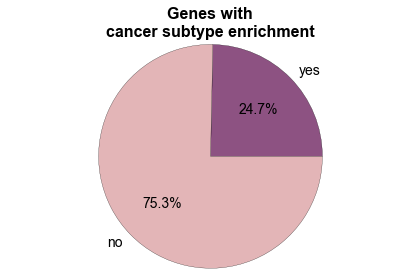

In [6]:
blue_pal = sns.cubehelix_palette(9) # sns.cubehelix_palette(9, start=.5, rot=-.75) # sns.cubehelix_palette(9) #sns.color_palette("Reds", 9)
counts = df['significant'].value_counts()
with sns.plotting_context('paper', font_scale=1.25):
    pie_colors = [ blue_pal[5], blue_pal[1],]
    labels = ['yes', 'no', ]
    patches, texts, autotexts = plt.pie(counts[labels], colors=pie_colors, labels=labels, 
                                        autopct='%.1f%%', textprops={'fontsize':14})
    [ _.set_fontsize(14) for _ in texts ]
    plt.title('Genes with\ncancer subtype enrichment', 
              fontdict={'verticalalignment': 'bottom', 'fontweight': 'bold', 'fontsize':16})
    _ = plt.axis('equal')
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_3c.pdf')

In [7]:
def format_dataframe(df, ctype):
    # only pick significant results for that cancer type
    cancer_type_df = df[(df['cancer type']==ctype) & (df['q-value']<=0.1)].copy()

    # split the information about subtypes
    split_df = cancer_type_df['subtype information'].str.split(';', expand=True)

    # extract out the percentages
    percent_df = split_df.applymap(lambda x: x.split('%')[0]).astype(float)
    subtypes = split_df.iloc[0,:].apply(lambda x: x.split(',')[-1][:-1]).values
    n = split_df.iloc[0,:].apply(lambda x: x.split(',')[0].split('/')[-1]).values
    subtypes = subtypes + ' (n=' + n + ')'
    percent_df.columns = subtypes

    # add the information about the percentage of samples mutated
    cancer_type_df = pd.concat([cancer_type_df, percent_df], axis=1)

    # set the index to be the gene names
    cancer_type_df = cancer_type_df.set_index('gene', drop=False)
    
    return cancer_type_df[subtypes].T

In [8]:
def create_heatmap(mydf, ctype):
    cmap = mpl.colors.ListedColormap(['#ffffff']+sns.cubehelix_palette(100, start=.5, rot=-.75).as_hex()[0:100])

    type2color = {'missense': "#3498db", 'inactivating': "#e74c3c"}
    
    with sns.plotting_context('paper'):
        ax = sns.heatmap(mydf, 
                    annot=True, linecolor='gray', 
                    linewidth=.5, square=True,
                    fmt='.3g',
                    vmin=0, vmax=50.,
                    xticklabels=1,
                    #row_colors=cancer_type_df['mutation type'].apply(lambda x: type2color[x]),
                    #col_cluster=False,
                    #cbar_kws={'fraction': .02},
                    #cbar=False,
                    cmap=cmap)
        #cg.ax_row_dendrogram.set_visible(False)
        


        # make sure tick labels are rotated in the appropriate manner
        _ = plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
        _ = plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

        # remove x/y labels
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # remove ticks
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

        # add cancer type as title
        ax.set_title(ctype)

        # fudge figure size to be compatible
        vertical_fudge = 3
        horizontal_fudge = 3
        if plot_df.shape[1] <= 2: horizontal_fudge -= 4
        if plot_df.shape[0] <= 2: vertical_fudge -= 4
        
        base_genes = 5.
        base_subtypes = 5.
        nsubtypes, ngenes = plot_df.shape
        myfig = plt.gcf()
        myfig.set_size_inches(ngenes/base_genes*4, nsubtypes/base_subtypes*5)
    
    return myfig, ax

In [10]:
#cancer_type = 'READ'
for cancer_type in df['cancer type'].unique():
    plot_df = format_dataframe(df, cancer_type)
    fig, ax = create_heatmap(plot_df, cancer_type)
    if plot_df.shape[1] > 2:
        plt.tight_layout()
    plt.savefig('CHASMplus/figures/subtype_analysis/{0}.pdf'.format(cancer_type))
    plt.clf()

In [14]:
format_dataframe(df, 'UCEC')

gene,PIK3CA,CTNNB1,PPP2R1A,PTEN,FGFR2,MAP3K1,TP53,NFE2L2,CTCF,KRAS,PIK3R2,CHD3
CN_HIGH (n=146),28.08,2.05,30.14,10.27,2.74,0.00,54.79,0.00,0.00,4.79,0.00,0.00
CN_LOW (n=118),48.31,43.22,1.69,32.20,11.02,0.85,4.24,5.08,1.69,16.95,0.85,0.00
MSI (n=109),49.54,12.84,2.75,38.53,11.93,2.75,8.26,7.34,6.42,33.94,5.50,0.92
POLE (n=6),83.33,50.00,0.00,66.67,0.00,16.67,16.67,0.00,16.67,33.33,0.00,16.67
